# Projet CSAA - Classification du rythme cardiaque issu d'ECG


Ce jeu de données est composé d'une collections de signaux de battements cardiaques provenant d'un jeu de données célèbres dans le domaine de la classification des battements cardiaques, le jeu de données sur l'arythmie du MIT-BIH.

Les signaux correspondent à des formes d'électrocardiogramme (ECG) de battements cardiaques pour le cas normal et les cas affectés par différentes arythmies et infarctus du myocarde. Ces signaux sont prétraités et segmentés, chaque segment correspondant à un battement cardiaque.

<img src="./DataECG.png" width="800" height="600">

On distingue 5 battements cardiaques différents : Battements normaux', 'Battements inconnus', 'Battements ectopiques ventriculaires', 'Battements ectopiques supraventriculaires' et 'Battements de fusion'.

De ces signaux, on extrait des caractéristiques par la librairie TSFEL - *Time Series Features Extraction Library* (https://tsfel.readthedocs.io/en/latest/index.html)

Les 156 caractéristiques extraites sont divisées selon les domaines :
- temporel avec 31 caractéristiques comme l'entropie, Max, Min, Absolute Energy ...
- statistique avec 14 caractéristiques comme écart moyen absolu, écart médian, variance, Kurtosis...
- spectral  avec 111 caractéristiques comme les coefficients FFT par bande de fréquence, ondelettes...

Lien vers le papier expliquant TSFEL : https://www.sciencedirect.com/science/article/pii/S2352711020300017

In [6]:
# Librairies utiles
import numpy as np
import sklearn 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Chargement des données d'apprentissage et de test

In [8]:
# Chargement des données d'apprentissage
DataFeatureApp=np.load('./DataApp.npy')
LabelApp=np.load('./LabelApp.npy')
print('Taille de la base d apprentissage :', DataFeatureApp.shape, LabelApp.shape)

# Chargement des données de test
DataFeatureTest=np.load('./DataTest.npy')
LabelTest=np.load('./LabelTest.npy')
print('Taille de la base d apprentissage :', DataFeatureTest.shape, LabelTest.shape)

Taille de la base d apprentissage : (5000, 156) (5000,)
Taille de la base d apprentissage : (750, 156) (750,)


# Chargement des variables issues *TSFEL*

In [9]:
ListeVariablesStat=np.load('./ListeVariableStat.npy',allow_pickle=True)
print('Nombre de variables statistiques :',ListeVariablesStat.shape)
#print('Liste Variables Statistiques :', ListeVariablesStat)

ListeVariablesTemps=np.load('./ListeVariableTemps.npy',allow_pickle=True)
print('Nombre de variables temporelles :',ListeVariablesTemps.shape)
#print('Liste Variables Temporelles :',ListeVariablesTemps)

ListeVariablesSpectral=np.load('./ListeVariableSpectral.npy',allow_pickle=True)
print('Nombre de variables spectrales :',ListeVariablesSpectral.shape)
#print('Liste Variables Spectrales :',ListeVariablesSpectral)

Nombre de variables statistiques : (31,)
Nombre de variables temporelles : (14,)
Nombre de variables spectrales : (111,)


### Fonctions pour réaliser une table de correspondance entre le label des approches non supervisées et le label réel

In [11]:


from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

def retrieve_info(cluster_labels,y_train):
 #Associe l'étiquette la plus probable à chaque groupe dans le modèle KMeans.
 #Résultats : dictionnaire des clusters associés à chaque étiquette.

# Initialisation
  reference_labels = np.zeros((len(np.unique(cluster_labels)),1))
# Loop pour chaque label
  for i in range(len(np.unique(cluster_labels))):
    index = np.where(cluster_labels == i,1,0)
    num = np.bincount(y_train[index==1].astype(int)).argmax()
    reference_labels[i] = num
  return reference_labels

def correspondance(y_pred_kmeans,y_train):
  # Correspondance entre la partition et les classes de la vérité terrain
  reference_labels = retrieve_info(y_pred_kmeans,y_train)
  number_labels = np.zeros(len(y_pred_kmeans))
  for i in range(len(y_pred_kmeans)):
    number_labels[i] = reference_labels[y_pred_kmeans[i]]
  return number_labels


# Partie I : Classification des battements cardiaques sans prétraitement

Réaliser une classification des battements cardiaques par une méthode d'apprentissage supervisé et une méthode d'apprentissage non supervisé de votre choix en utilisant soit les codes des TP précédents, soit en utilisant la librairie *scikit-learn*.

Pour chaque résultat obtenu, calculer la matrice de confusion et interpréter les résultats.


## Méthodes supervisées  :
indiquer quelles sont les 2 méthodes supervisées de votre choix et calculer la matrice de confusion associée.

Le taux de précision pour la Gaussian naive bayes est : 62.6 %


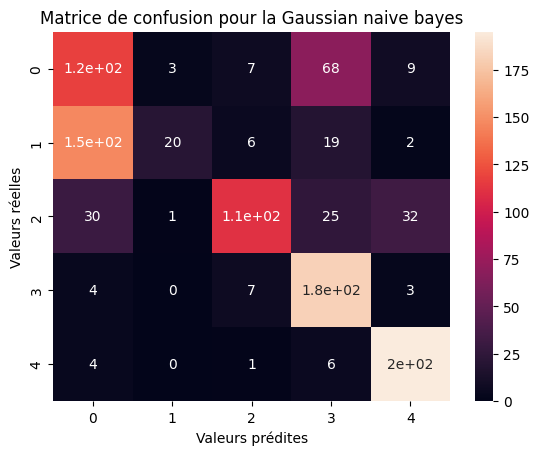

Le taux de précision pour l arbre de decision est : 87.6 %


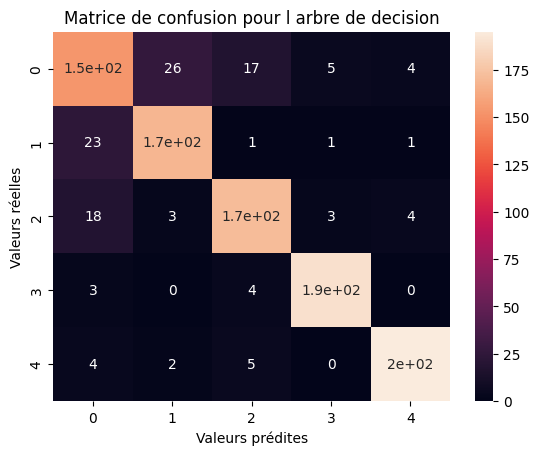

In [13]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

#diviser les données en données d'apprentissage et de test
X_train,X_test,y_train,y_test=train_test_split(DataFeatureApp,LabelApp,test_size=0.2,random_state=0)
#normaliser les données
scale=StandardScaler()
X_train=scale.fit_transform(X_train)
X_test=scale.transform(X_test)
# Gaussian Naive Bayes
Gauss=GaussianNB()
Gauss.fit(X_train,y_train)
y_pred=Gauss.predict(X_test)
#calculer la matrice de confusion
confusion_matrix(y_test,y_pred)
#calculer le taux de precision
acuray_score=accuracy_score(y_test,y_pred)
print('Le taux de précision pour la Gaussian naive bayes est :',acuray_score*100,"%")
plt.figure()
sns.heatmap(confusion_matrix(y_test,y_pred),annot=True)
plt.title('Matrice de confusion pour la Gaussian naive bayes')
plt.xlabel('Valeurs prédites')
plt.ylabel('Valeurs réelles')
plt.show()

# Arbre de decision
tree=DecisionTreeClassifier()
tree.fit(X_train,y_train)
y_pred=tree.predict(X_test)
#calculer la matrice de confusion
confusion_matrix(y_test,y_pred)
#calculer le taux de precision
acuray_score=accuracy_score(y_test,y_pred)
print('Le taux de précision pour l arbre de decision est :',acuray_score*100,"%")
plt.figure()
sns.heatmap(confusion_matrix(y_test,y_pred),annot=True)
plt.title('Matrice de confusion pour l arbre de decision')
plt.xlabel('Valeurs prédites')
plt.ylabel('Valeurs réelles')
plt.show()
#confusion_matrix(y_true, y_pred)

## Méthodes non supervisées

Indiquer quelles sont les 2 méthodes non supervisées de votre choix et calculer la matrice de confusion associée.

Taille de la base d apprentissage : (5000,)
[0. 1. 2. 3. 4.]
[0. 1. 2. 3. 4.]
Le taux de précision pour la méthode non supervisée Kmeans est : 40.42 %
[[200 267  88 382  63]
 [141 411 153 247  48]
 [ 13 284 375 104 224]
 [ 81 260  30 623   6]
 [ 53 149 134 252 412]]


/tmp/ipykernel_47061/1934617832.py:24: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  number_labels[i] = reference_labels[y_pred_kmeans[i]]


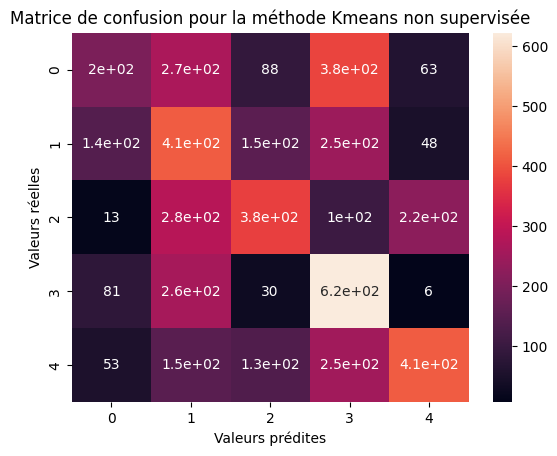

In [14]:
from sklearn.cluster import KMeans

k_means = KMeans(n_clusters=5, random_state=0)

y_train = LabelApp
y_pred_kmeans = k_means.fit_predict(DataFeatureApp)
print('Taille de la base d apprentissage :', y_pred_kmeans.shape)
y_pred = correspondance(y_pred_kmeans,y_train) # les classes prédites pour la methodes non superviser
print(np.unique(y_pred))
print(np.unique(y_train))

acuray_score=accuracy_score(y_train,y_pred)
print('Le taux de précision pour la méthode non supervisée Kmeans est :',acuray_score*100,"%")

matrice_confusion=confusion_matrix(y_train,y_pred)
print(matrice_confusion)
plt.figure()
sns.heatmap(matrice_confusion,annot=True)
plt.title('Matrice de confusion pour la méthode Kmeans non supervisée')
plt.xlabel('Valeurs prédites')
plt.ylabel('Valeurs réelles')
plt.show()

In [ ]:
#Classification Ascendant Hiérarchies

import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import fcluster
from sklearn.preprocessing import LabelEncoder

# 1. Calcul des distances entre les points
distances = pdist(DataFeatureApp, metric='euclidean')

# 2. Application de la méthode de fusion ascendante
Z = sch.linkage(distances, method='ward')

num_clusters = 5
clusters = fcluster(Z, num_clusters, criterion='maxclust')


label_encoder = LabelEncoder()
cluster_labels = label_encoder.fit_transform(clusters)  # Convert clusters to color indices

# Dimensions pour la grille (carré ou presque carré)
num_points = len(clusters)
grid_size = int(np.ceil(np.sqrt(num_points)))  # Dimensions de la grille

# Créer une matrice carrée remplie de -1 (pour les cases vides, si nécessaire)
grid = -np.ones((grid_size, grid_size))
grid.flat[:num_points] = cluster_labels  # Remplir les premières cases avec les labels

# 5. Visualisation de la matrice de clusters avec un colormap
plt.figure(figsize=(8, 8))
plt.imshow(grid, cmap='tab20', aspect='equal')  # Choix du colormap `tab20` pour des couleurs distinctes
plt.colorbar(ticks=range(num_clusters), label="Cluster")
plt.title("Visualisation des clusters en grille")
plt.axis('off')  # Masquer les axes
plt.show()



accuracy = accuracy_score(y_train, clusters)
print('Le taux de précision pour la méthode non supervisée est :',accuracy*100,"%")

: 

# Partie II : classification des battements cardiaques avec prétraitement par ACP

## Méthode supervisée avec réduction de dimension par ACP sur l'ensemble d'apprentissage
Réaliser une ACP sur l'ensemble d'apprentissage pour réduire la dimension, visualiser les données
puis projeter les données de l'ensemble de test dans la base de l'ACP.

Indiquer quelles sont les 2 méthodes supervisées de votre choix et calculer la matrice de confusion associée (confusion_matrix) et le score de performance (accuracy_score)

In [16]:
from sklearn.decomposition import PCA

In [ ]:
# Calcul de la matrice de confusion


## Méthode non supervisée avec réduction de dimension par ACP sur l'ensemble des données

Réaliser une ACP sur l'ensemble des données et indiquer quelles sont les méthodes non supervisées de votre choix et calculer la matrice de confusion associée (confusion_matrix) et le score de performance (accuracy_score)

In [ ]:
# Calcul de la matrice de confusion


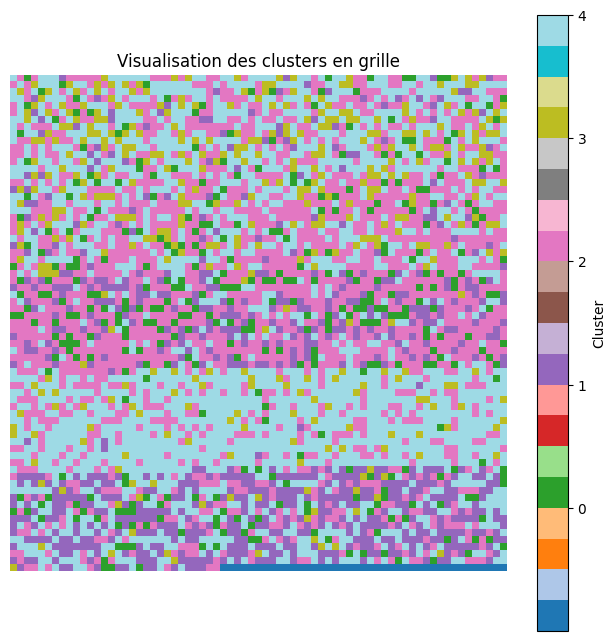

Le taux de précision pour la méthode de la clasification hirarchique ascendante non supervisée est : 10.9 %


In [24]:
#Classification Ascendant Hiérarchies PCA reduction

pca = PCA(n_components=2)  

X_train = pca.fit_transform(DataFeatureApp)

distances = pdist(X_train, metric='euclidean')

Z = sch.linkage(distances, method='ward')

num_clusters = 5
clusters = fcluster(Z, num_clusters, criterion='maxclust')


label_encoder = LabelEncoder()
cluster_labels = label_encoder.fit_transform(clusters)  

num_points = len(clusters)
grid_size = int(np.ceil(np.sqrt(num_points))) 

grid = -np.ones((grid_size, grid_size))
grid.flat[:num_points] = cluster_labels  

plt.figure(figsize=(8, 8))
plt.imshow(grid, cmap='tab20', aspect='equal')  
plt.colorbar(ticks=range(num_clusters), label="Cluster")
plt.title("Visualisation des clusters en grille")
plt.axis('off')  
plt.show()

 

accuracy = accuracy_score(y_train, clusters)
print('Le taux de précision pour la méthode de la clasification hirarchique ascendante non supervisée est :',accuracy*100,"%")


# Réaliser votre étude :

- Etudier les meilleurs paramètres pour les méthodes supervisées et non supervisées que vous avez choisies.
- Faire une étude sur les paramètres issus de TSFEL en séparant par exemple les différentes modalités (statistiques,temporelles et spectrales) ou en étudiant leur correlation et essayer de réaliser des prétraitements.
- Optimiser la réduction de dimensions par ACP
